#### Before all, here we introduce how to use GPU instead of CPU here for PyTorch calculation
I am using MacbookPro M3 16GB 1TB, there is an Apple GPU (MLS) that i can use. 
Below is the basic information

In [2]:
import torch
import platform

print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"MacOS version: {platform.mac_ver()[0]}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")    # Whether PyTorch is built with MPS (Metal Performance Shaders) support

Python version: 3.11.12
PyTorch version: 2.5.1
MacOS version: 26.0.1
MPS available: True
MPS built: True


### Here is my exploration of the classic METR-LA Dataset
#### What is it? 
It is the traffic speed reading from a certain amount of detectors on the highways of LA County over 4 months. The data is aggregated into 5 min intervals. 

#### What are we going to do here? 
Traffic prediction using GNN model, this is an important process of my learning path. 

In [2]:
# Here we import database we will need later
import torch    # Basic PyTorch library for tensor operations
import torch.nn as nn   # Building Neural Networks
import torch.nn.functional as F # Activation functions and other utilities
from torch_geometric_temporal.nn.recurrent import A3TGCN    # See below
from torch_geometric_temporal.dataset import METRLADatasetLoader    # Load the dataset
from torch_geometric.loader import DataLoader  # For batching and loading data
from tqdm import tqdm   # The visualization of processing progress
import matplotlib.pyplot as plt # For basic visualization
import seaborn as sns  # For advanced visualization
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis that i am familiar with

/Users/duhaolei/my-pytorch-project/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Here we first use the A3TGCN Model
1. What is it? -- It is Attention Temporal Graph Convolutional Network

2. What is the mechanism behind it? 

    1. *GCN* -- it learn from neighbors by averaging neighbors' features. 

    2. Temporal *T* -- For traffic, there is a mey feature *time*. While the standard GCN doen's know the time, we need sth to remember history, and think currently. E.g. GRU, which generally decides 'what to remember, what to forget' -- updating the message. 

    3. Attention *A* -- Which matters the most? *Attention* mechanism weights the input in every time step, learns to pay attention to specific patterns and ignores noise


In [116]:
# Now, we will load the METR-LA dataset and see what is inside
loader = METRLADatasetLoader()
# We will take the data from the time span of before 60 min to after 60 min
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

# Take a look at the data structure -- 
for snapshot in dataset:
    print(snapshot)
    break

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


##### How to understand the 'snapchot' object? It contains the following attributes:

1. x = [207, 2, 12] -- there are **Sensors, Features, Timesteps**

    It is just like there area 207 cameras at the fixed location along the highway. Each sensor records 2 features, which are speed and time of a day. '12' corresponds to our previous input, 12 steps backward. 

2. edge_index = [2, 1722] -- the **Road Network Topology**

    '2' indicates source -> target, it represents the real-world road connectivity. '1722' stands for 1722 road segments in total that are connecting the sensors.

3. edge_attr = [1722] -- This is the **Edge Weight**

    It is a weighted distributed number between 0 to 1, which here tells you how far is there between two sensors. 

4. y = [207, 12] -- This is **Future**

    We wanna predict all the 207 sensors, and '12' is the step forword. 



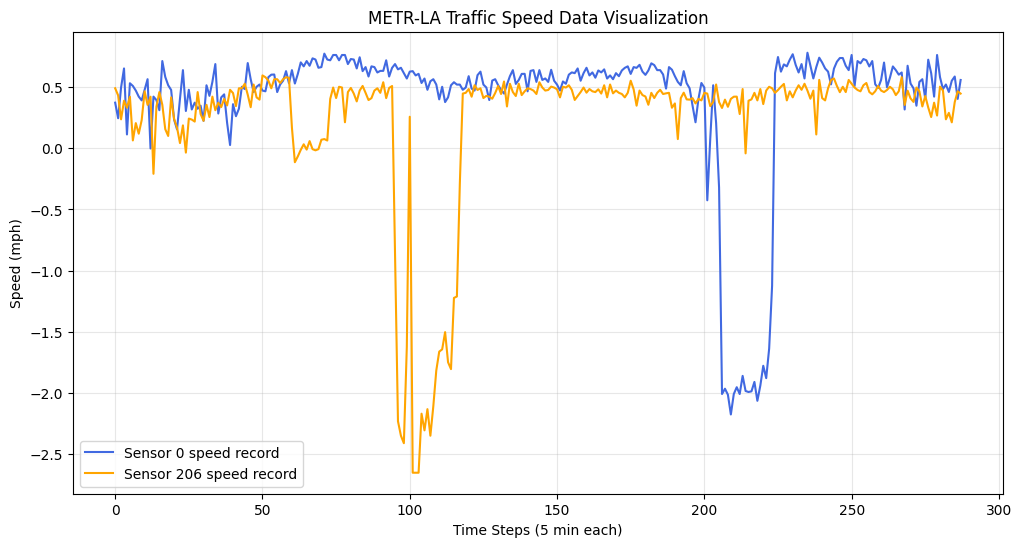

In [5]:
# We already know what is in the dataset, now we will visualize the data of METR-LA

# I dont know how to visualize every sensor's data in a clear but not messy way, 
# so here I just visualize two sensors' data for example
sensor_id0 = 0
sensor_id1 = 206
 # We will visualize the data of sensor 0
feature_index = 0   # speed value is at place 0 of the y tensor
time_steps_plt = 24 * 60 / 5    # 24 hours, each time step is 5 min, so total 288 time steps

speed_record0 = []
speed_record1 = []
for i, snapshot in enumerate(dataset):
    if i >= time_steps_plt:
        break
    speed_record0.append(snapshot.y[sensor_id0, feature_index].item())
    speed_record1.append(snapshot.y[sensor_id1, feature_index].item())


plt.figure(figsize=(12,6))
plt.plot(speed_record0,label=f'Sensor {sensor_id0} speed record',color='royalblue')
plt.plot(speed_record1,label=f'Sensor {sensor_id1} speed record',color='orange')
plt.grid(True,alpha=0.3)
plt.xlabel('Time Steps (5 min each)')
plt.ylabel('Speed (mph)')
plt.title('METR-LA Traffic Speed Data Visualization')
plt.legend()
plt.show()


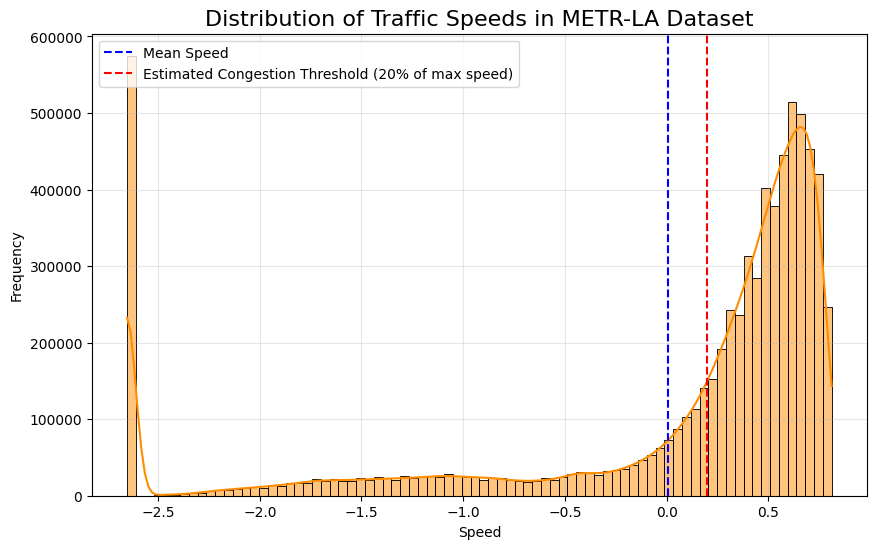

In [6]:
# After a simple visualization, we can see that the traffic speed has a clear daily pattern, 
# with peaks and troughs corresponding to rush hours and off-peak times. 
# Here will be the distribution of all recorded speed
all_speed = []

for snapshot in dataset:
    speed = snapshot.y[:,0].numpy()  # Get speed values and flatten to 1D array
    all_speed.extend(speed)

all_speed = np.array(all_speed)

plt.figure(figsize=(10,6))
sns.histplot(all_speed, bins=80, kde=True, color='darkorange')
plt.title('Distribution of Traffic Speeds in METR-LA Dataset',fontsize=16)
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.grid(True,alpha=0.3)
plt.axvline(x=np.mean(all_speed),color='blue',linestyle='--',label='Mean Speed')
plt.axvline(x=0.2, color='red',linestyle='--',label='Estimated Congestion Threshold (20% of max speed)')
plt.legend()
plt.show()

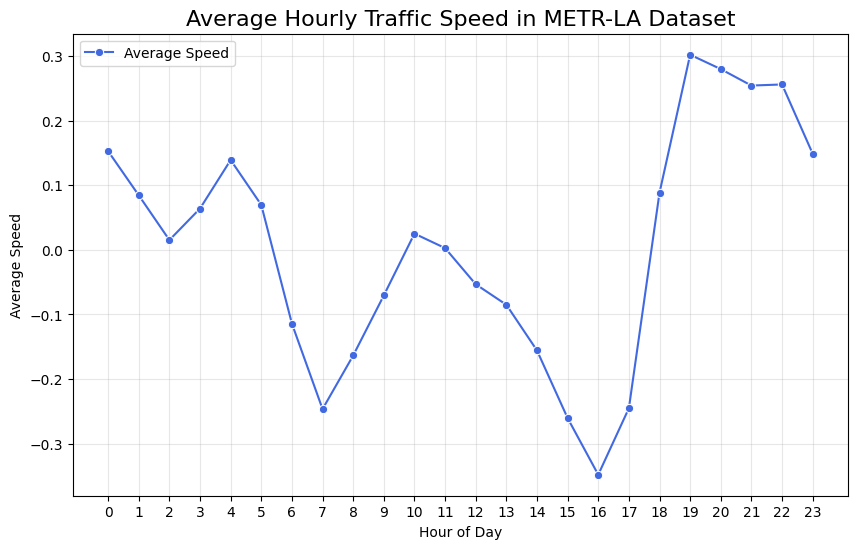

In [7]:
# From the above graph, we can tell that the speed is not uniformly distributed
# Here we will visualize the average hour speed over a day
hour_mean_speeds = []

for snapshot in dataset:
    current_mean = snapshot.x[:,0,-1].mean().item()
    hour_mean_speeds.append(current_mean)

df = pd.DataFrame({
    'speed': hour_mean_speeds
})
df['time_step'] = df.index
df['hour_of_day'] = (df.index //12) % 24  # Each hour has 12 time steps (5 min each)

hourly_avg = df.groupby('hour_of_day')['speed'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='royalblue',label='Average Speed')
plt.title('Average Hourly Traffic Speed in METR-LA Dataset', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed')
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

####    Here is the interpretation of the graphic information -- Behind the 
####    *Recurrent Congestion Pattern*. 
1. What is *Recurrent Congestion Pattern*? 

    'Rush Hour', here the congestion pattern is observed during 6-8 am and 3-5 pm

2. What is *Temporal Heterogeneity*? 

    The average speed detected by nodes are varying from time. 

3.  What is *Phase Transition*? 

    From free-flow to congested states. 

4. What is *Traffic Oscillations*?

    Sharp local variations in speed, which indicated the stop-go waves. 

Node 0 and Node 111  are connected: True


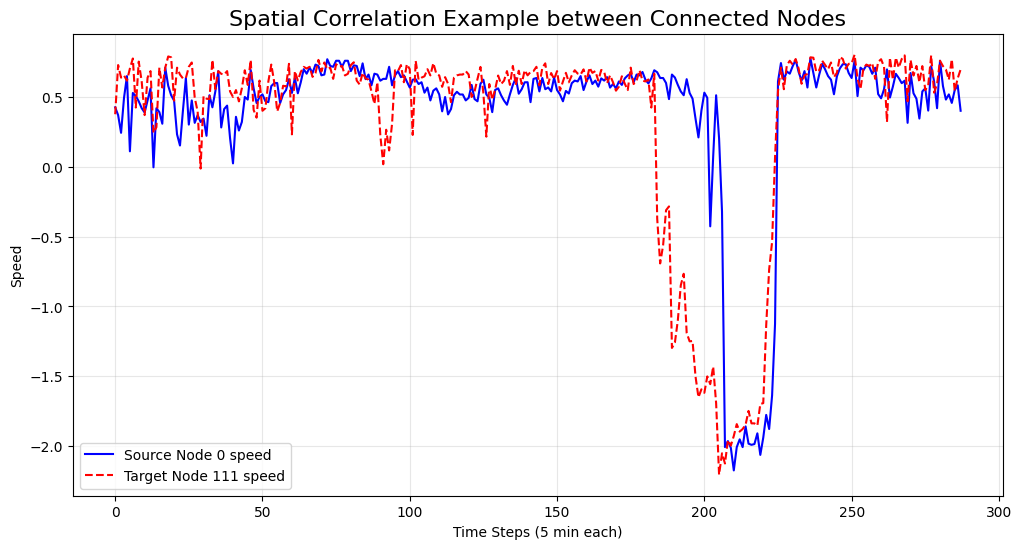

In [8]:
# Now we pick two connected noeds from the graph to see their connection
# 5 mean 5th road on the list
# 0 -> 1 mean from row0 in edge_index to row1, indicating a directed edge from source to target
source = dataset[0].edge_index[0,5].item()
target = dataset[0].edge_index[1,5].item()

is_connected = ((dataset[0].edge_index[0] == source) & (dataset[0].edge_index[1] == target)).any()

print(f"Node {source} and Node {target}  are connected: {is_connected}")

source_speed = []
target_speed = []
for i in range(288):
    source_speed.append(dataset[i].x[source,0,-1].item())
    target_speed.append(dataset[i].x[target,0,-1].item())

plt.figure(figsize=(12,6))
plt.plot(source_speed,label=f'Source Node {source} speed',color='blue')
plt.plot(target_speed,label=f'Target Node {target} speed',color='red',linestyle='--')
plt.title('Spatial Correlation Example between Connected Nodes', fontsize=16)
plt.xlabel('Time Steps (5 min each)')
plt.ylabel('Speed')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

##### What can we know from two connected sensor? 
There is a *Traffic Shockwave*. 

1. What is it?
    The boundary between two different traffic states. 
    E.g. You see red traffic light ahead of you, so you slow down your car suddenly. Later a car behind you sees it and slowed down few second later. Here there is a backward moving 'wave', from sensor $i$ to sensor $i-1$. 

2. According to the above graph:
    Taking the rush hour period as an example, this represents a congestion shockwave -- at time 180 (approximately), the target node's speed dropped dramatically first, indicating that there is a severe congestion taking place suddenly. Shortly after that (a temporal lag), the source node's speed dropped, which means the coming cars are slowed down by the ongoing congestion ahead. 



#### Here we will config a simple GNN model

In [9]:
class TemporalGNN(nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN,self).__init__()
        # Here we will use A3TGCN (mentioned above) as our temporal GNN layer
        # periods indicate how many different time periods before we want to consider
        self.tgnn = A3TGCN(in_channels=node_features,out_channels=32,periods=periods)
        self.linear = nn.Linear(32, 1)

    def forward(self,x,edge_index,edge_weight):
        # this step has a temporal attention mechanism inside
        # the different time period due to right now has different influence on the prediction
        # the closest period has the most influence, and the furthest period has the least influence
        # also, this step does the GCN work -- it looks at the neighbors' information to update the node features
        # the information is aggregated based on the edge_index and edge_weight
        h = self.tgnn(x,edge_index,edge_weight)
        # ReLU is the modeling phase transition in this traffic prediction context
        # WHY? -- a linear model cannot learn from the rapid and sharp changes in traffic conditions
        # ReLU introduces non-linearity, allowing the model to capture complex patterns and sudden shifts in traffic data
        h = F.relu(h)
        h = self.linear(h)
        return h

#### After the model is initially configured, we will train it. 

In [3]:
# Setup the device for computation
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
PIN_MEMORY=True

In [149]:
train_dataset = list(dataset)
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,pin_memory=PIN_MEMORY)

#### A-OH, here we have an important problem:
My MPS has 20GB of unfied memory, but my initial code crashes it. 

We were forcing the model to keep the history of every computation step simultaneously. Apparently my laptop cannot manage to do this. 

And, the initial code is using Stohastic Gradient Descent -- using a gpu as a small calculator. 

#### What should I do?
After stucking here for 1 day, I figured out how dumb I am. 


It is not a good idea to let my gpu go through each snapshot one by one. 
Instead, we can divide them into several batch, and let the batched be processed at the same time for each epoch. 

#### After almost burning my laptop, I still cannot run it. 
#### So i will run the below code in Colab. 

In [147]:
torch.mps.empty_cache()
model = TemporalGNN(node_features=2,periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)    # Manually setup learning rate of Gradient Descent optimizer as 0.01
loss_fn = torch.nn.L1Loss()
model.train()

print('Starting training process...')


for epoch in range(1,21):   # Train for 20 epochs
    epoch_loss = 0
    step = 0
    progressor = tqdm(train_loader,desc=f'Epoch {epoch:02d}',leave=False)
    for batch in progressor:
        batch = batch.to(device)

        optimizer.zero_grad()
        # This is how we get the prediction from the model

        y_hat = model(batch.x, batch.edge_index, batch.edge_attr)

        # Here we calculate the loss between the prediction and the ground truth
        # INITIALLY TRIAL i use MSE, but soon i will use more feasible method here
        loss = loss_fn(y_hat, batch.y)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent exploding gradients

        optimizer.step()
        epoch_loss += loss.item()
        step += 1

    avg_loss = epoch_loss / step
    print(f'Epoch {epoch:02d}, Average MSE Loss: {avg_loss:.4f}')

print('Training process finished.')

Starting training process...


Epoch 01:   0%|          | 0/1071 [00:00<?, ?it/s]/Users/duhaolei/my-pytorch-project/torch_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([6624, 12])) that is different to the input size (torch.Size([6624, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 